<a href="https://colab.research.google.com/github/ShivaniSarkate/Sales-Insights-Demand-Forecasting-for-a-Retail-Chain/blob/main/Capstone_ShivaniSarkate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

(421570, 5) (8190, 12) (115064, 4) (45, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday_x   421570 non-null  bool          
 5   Temperature   421570 non-null  float64       
 6   Fuel_Price    421570 non-null  float64       
 7   MarkDown1     150681 non-null  float64       
 8   MarkDown2     111248 non-null  float64       
 9   MarkDown3     137091 non-null  float64       
 10  MarkDown4     134967 non-null  float64       
 11  MarkDown5     151432 non-null  float64       
 12  CPI           421570 non-null  float64       
 13  Unemployment  421570 non-null  float64       
 14  IsHoliday_y   421570 non-

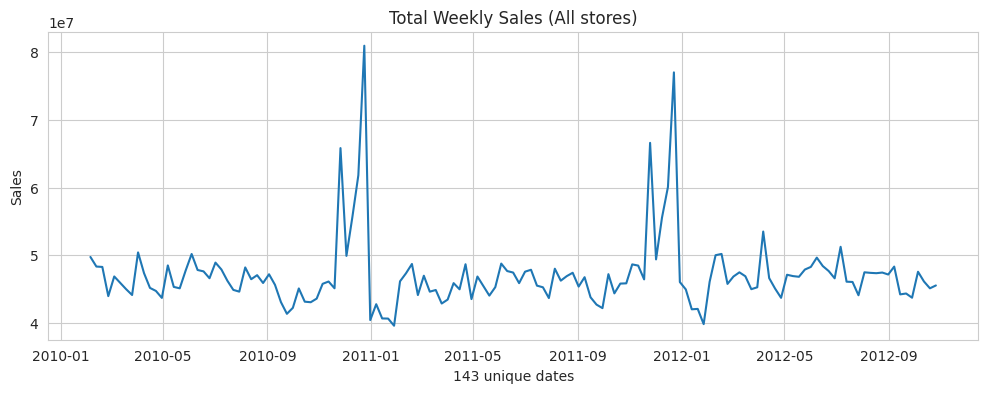

avearge sales - NonHoliday vs Holiday:
 IsHoliday
False    15901.445069
True     17035.823187
Name: Weekly_Sales, dtype: float64


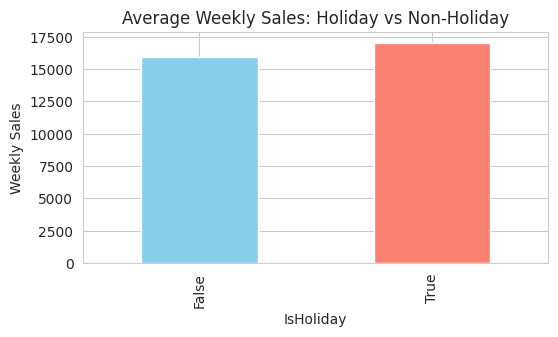

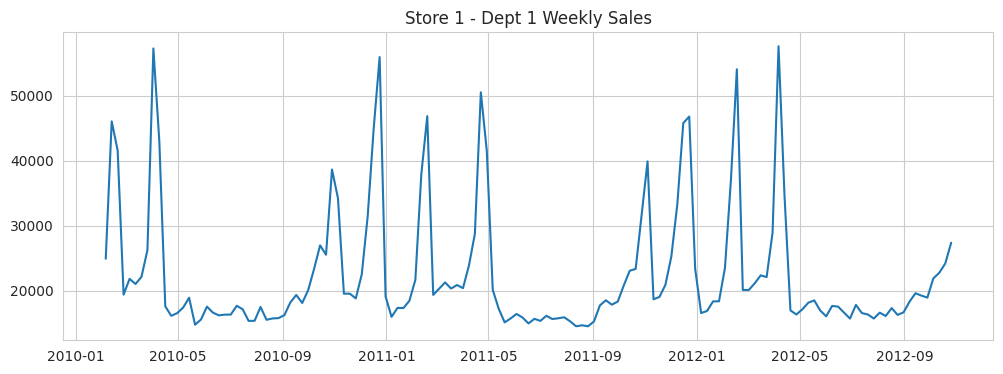

After dropna: (382955, 27)
Train size: (347478, 18)
Validation size: (35477, 18)
Baseline RMSE: 3432.643782628198
Baseline MAE: 1503.7636178369085
Baseline MAPE: 421569040.2574355
XGB RMSE: 2697.9023334515514
XGB MAE: 1276.8654476259
XGB MAPE: 1129885759.5167098


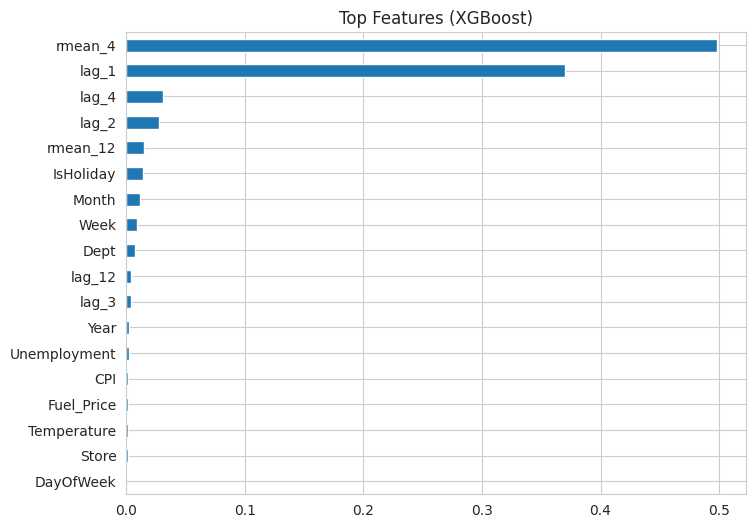

Forecast saved as xgb_forecast_output.csv


In [11]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

#STEP 1: LIBRARIES AND IMPORT DATA

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBRegressor
#from xgboost.callback import EarlyStopping # Import EarlyStopping callback - REMOVED: not needed for older API
import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

# load files

train = pd.read_csv('/content/train.csv', parse_dates=['Date'])
features = pd.read_csv('/content/features.csv', parse_dates=['Date'])
test = pd.read_csv('/content/test.csv')
store = pd.read_csv('/content/stores.csv')

print(train.shape, features.shape, test.shape, store.shape)
train.head()

#STEP 2: Merge files

df = pd.merge(train, features, on=['Store','Date'], how='left')
df = pd.merge(df, store, on = 'Store', how = 'left')
df.sort_values(['Store','Dept','Date'], inplace=True)
df.reset_index(drop=True, inplace=True)

df.info()

#STEP 3: Missing values + data check

df.drop('IsHoliday_x',axis = 1, inplace = True)
df = df.rename(columns = {'IsHoliday_y':'IsHoliday'})
print("Missing per column:\n", df.isnull().sum())

# basic stats
df.describe(include='all')

print("\nDate range:", df['Date'].min(), "to", df['Date'].max())

#STEP 4: Overall sales trend

agg = df.groupby('Date')['Weekly_Sales'].sum().reset_index().sort_values(by='Date', ascending=True)

#visualize

plt.figure(figsize=(12,4))
plt.plot(agg['Date'], agg['Weekly_Sales'])
plt.title('Total Weekly Sales (All stores)')
plt.xlabel('143 unique dates'); plt.ylabel('Sales')
plt.show()

#STEP 5: Holiday effect check
holiday_sales = df.groupby('IsHoliday')['Weekly_Sales'].mean()
print("avearge sales - NonHoliday vs Holiday:\n", holiday_sales)

holiday_sales.plot(kind='bar', figsize=(6,3),color=['skyblue','salmon'])
plt.title('Average Weekly Sales: Holiday vs Non-Holiday')
plt.ylabel('Weekly Sales')
plt.show()

#STEP 6: Visualize sales for a sample store-dept

s = df[(df.Store==1) & (df.Dept==1)].copy()
plt.figure(figsize=(12,4))
plt.plot(s['Date'], s['Weekly_Sales'])
plt.title('Store 1 - Dept 1 Weekly Sales')
plt.show()

#STEP 7: Feature engineering - time features + lags + rolling
# basic time feature

df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Week'] = df['Date'].dt.isocalendar().week
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['IsHoliday'] = df['IsHoliday'].astype(int)

# 7.1 - create lags and rolling per store-dept

lag_list = [1,2,3,4,12]   # weeks
for lag in lag_list:
    df[f'lag_{lag}'] = df.groupby(['Store','Dept'])['Weekly_Sales'].shift(lag)

df['rmean_4'] = df.groupby(['Store','Dept'])['Weekly_Sales'].shift(1).rolling(window=4).mean()
df['rmean_12'] = df.groupby(['Store','Dept'])['Weekly_Sales'].shift(1).rolling(window=12).mean()
# 7.2 - fill external regressors missing (forward/backfill small gaps)

df[['Temperature','Fuel_Price','CPI','Unemployment']] = df[['Temperature','Fuel_Price','CPI','Unemployment']].fillna(method='ffill').fillna(method='bfill')

#STEP 8: Prepare modeling dataset (drop rows with NaN lags)

# 8.0 - drop initial rows with NaNs from lags

model_df = df.dropna(subset=[f'lag_{l}' for l in lag_list] + ['rmean_4']).copy()
print("After dropna:", model_df.shape)
# choose feature cols
feature_cols = ['Store','Dept','Year','Month','Week','DayOfWeek','IsHoliday',
                'Temperature','Fuel_Price','CPI','Unemployment'] + \
               [f'lag_{l}' for l in lag_list] + ['rmean_4','rmean_12']
target_col = 'Weekly_Sales'
model_df[feature_cols].head()

#STEP 9: Time-based train/validation split
# Last 12 weeks = validation, rest = training

cutoff_date = model_df['Date'].max() - pd.Timedelta(weeks=12)

train = model_df[model_df['Date'] <= cutoff_date]
val   = model_df[model_df['Date'] > cutoff_date]

X_train, y_train = train[feature_cols], train[target_col]
X_val, y_val     = val[feature_cols],   val[target_col]

print("Train size:", X_train.shape)
print("Validation size:", X_val.shape)

#STEP 10: Baseline: naive last-week predictor

# 10.0 - baseline using lag_1

y_pred_base = X_val['lag_1'].values
def mape(y_true,y_pred): return np.mean(np.abs((y_true - y_pred)/ (y_true + 1e-9))) * 100
print("Baseline RMSE:", np.sqrt(mean_squared_error(y_val, y_pred_base)))
print("Baseline MAE:", mean_absolute_error(y_val, y_pred_base))
print("Baseline MAPE:", mape(y_val, y_pred_base))

#STEP 11: Train XGBoost
# 11.0 - train XGBoost regressor
xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    verbosity=0
)

# Define the EarlyStopping callback - THIS SECTION IS REMOVED/COMMENTED OUT
# early_stopping_callback = EarlyStopping(
#     rounds=50,
#     min_delta=0,
#     maximize=False
# )

xgb.fit(X_train, y_train,
        eval_set=[(X_val, y_val)],
        #callbacks=[early_stopping_callback] # Pass the callback here - REMOVED
        #early_stopping_rounds=50, # Removed: not supported by this XGBoost version
        verbose=False # Set verbose to False to avoid verbose output for each round
)

# Predict + eval
y_pred = xgb.predict(X_val)
print("XGB RMSE:", np.sqrt(mean_squared_error(y_val, y_pred)))
print("XGB MAE:", mean_absolute_error(y_val, y_pred))
print("XGB MAPE:", mape(y_val, y_pred))

#STEP 12: Feature importance (XGBoost)
# 12.0 - feature importance
imp = pd.Series(xgb.feature_importances_, index=feature_cols).sort_values(ascending=False)
plt.figure(figsize=(8,6))
imp.head(20).plot(kind='barh')
plt.title('Top Features (XGBoost)')
plt.gca().invert_yaxis()
plt.show()

#12. Business insights & recommendations (final)
# - Holidays drive big uplifts. Plan inventory/staffing for known holiday weeks.
# - Recent sales (lag_1, rolling mean) are strongest predictors → short-term momentum matters.
# - External regressors (CPI, Unemployment, Fuel_Price) add small but useful signal.
# - Use XGBoost global model for automated weekly predictions; use Prophet for per-store communication.
# - For production: build iterative prediction pipeline that updates lags each week and ingests known holiday calendar.

# 13. Forecast next N weeks

# Step 1: create future dates same way you created lags earlier
last_date = df['Date'].max()
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=7), periods=12, freq='W-MON')

# Step 2: build future features (lags, rolling means, holidays, store/dept)
# Note: For production-ready pipeline you’d automate lag creation, here is a simple placeholder
future_df = pd.DataFrame({'Date': future_dates})

# Example: keep it minimal if no external regressors prepared
X_future = df[feature_cols].iloc[-12:]   # reuse last 12 rows’ structure for demo

# Step 3: predict
y_future = xgb.predict(X_future)

# Step 4: save results
forecast_df = pd.DataFrame({
    "Date": future_dates,
    "Forecasted_Sales": y_future
})
forecast_df.to_csv("xgb_forecast_output.csv", index=False)
print("Forecast saved as xgb_forecast_output.csv")